### Purpose
My goal is to learn how to scrape data using python.

This is my first time scraping from the web. I found this documentation *extremely* helpful http://www.gregreda.com/2015/02/15/web-scraping-finding-the-api/. Here, I'm pulling in the shot log for Andrew Wiggins, the NBA Rookie of the Year last year.

In [18]:
%matplotlib inline
import requests
import json
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

To get the info needed, you can navigate to the website that gives the data you want. Using Chrome developer tools, you can navigate to find the API and see the structure of the request by previewing it.

In [19]:
shotsUrl = 'http://stats.nba.com/stats/playerdashptshotlog?DateFrom=&DateTo=&' + \
    'GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&' + \
    'OpponentTeamID=0&Outcome=&Period=0&PlayerID=203952&Season=2014-15' + \
    '&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision='

Now, use requests to get the data back in json format 

In [20]:
response = requests.get(shotsUrl)
response.raise_for_status()
shots = response.json()['resultSets'][0]['rowSet']
colNames = response.json()['resultSets'][0]['headers']

Now, having all the data in memory, arrange it and put it in a dataframe.

In [21]:
dfShots = pd.DataFrame(shots,columns=colNames)
dfShots.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS
0,0021401222,"APR 15, 2015 - MIN vs. OKC",H,L,-25,1,1,11:23,11.9,1,3.6,10.5,2,missed,"Roberson, Andre",203460,3.0,0,0
1,0021401222,"APR 15, 2015 - MIN vs. OKC",H,L,-25,2,1,5:34,9.5,2,4.2,12.2,2,made,"Morrow, Anthony",201627,2.3,1,2
2,0021401222,"APR 15, 2015 - MIN vs. OKC",H,L,-25,3,1,1:58,6.0,0,1.0,24.5,3,missed,"Kanter, Enes",202683,7.0,0,0
3,0021401222,"APR 15, 2015 - MIN vs. OKC",H,L,-25,4,2,10:46,14.9,0,0.9,24.9,3,missed,"Collison, Nick",2555,7.4,0,0
4,0021401222,"APR 15, 2015 - MIN vs. OKC",H,L,-25,5,2,7:12,14.8,1,2.2,4.2,2,missed,"Adams, Steven",203500,3.3,0,0


There's a lot of data here. Let's just start with a quick analysis of how much time was on the shot clock when Wiggins shot the ball.

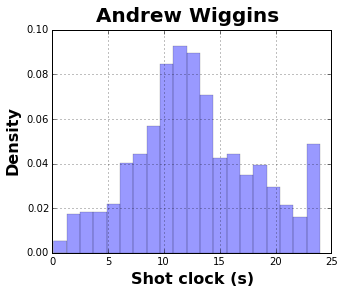

In [22]:
allShots = dfShots[np.invert(np.isnan(dfShots.SHOT_CLOCK))]
fig = plt.figure(figsize=(5,4), dpi=1600)
ax = fig.add_subplot(111)
allShots['SHOT_CLOCK'].hist(normed = True,bins=20,alpha=0.4,linewidth=0.4)
ax.set_xlabel('Shot clock (s)',fontsize=16,fontweight='bold')
ax.set_ylabel('Density',fontsize=16,fontweight='bold')
fig.suptitle('Andrew Wiggins',fontsize=20,fontweight='bold')
#plt.show()

We can continue to dig into the data. Next let's just compare the same data divided into made shots and missed shots.

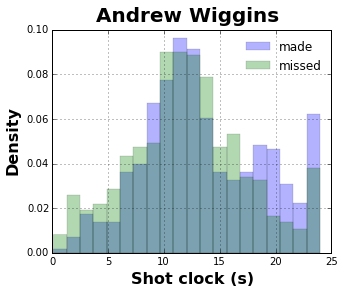

In [23]:
fig = plt.figure(figsize=(5,4), dpi=1600)
ax = fig.add_subplot(111)

madeShots = dfShots[(dfShots.SHOT_RESULT=='made') & (np.invert(np.isnan(dfShots.SHOT_CLOCK)))]
#madeShots = allShots[allShots.SHOT_RESULT=='made']
missedShots = dfShots[(dfShots.SHOT_RESULT=='missed') & (np.invert(np.isnan(dfShots.SHOT_CLOCK)))]

madeShots['SHOT_CLOCK'].hist(normed = True,bins=20,alpha=0.3,linewidth=0.4,label='made')
missedShots['SHOT_CLOCK'].hist(normed = True,bins=20,alpha=0.3,linewidth=0.4,label='missed')
plt.legend(loc='upper right',framealpha=0)

ax.set_xlabel('Shot clock (s)',fontsize=16,fontweight='bold')
ax.set_ylabel('Density',fontsize=16,fontweight='bold')
fig.suptitle('Andrew Wiggins',fontsize=20,fontweight='bold')
plt.show()

It looks like the missed shots and made shots pretty much overlap. A couple of interesting points. The made shots density is relatively higher with more time left on the shot clock. This is probably due to quick put-back shots. At low time left, the missed is slightly higher, suggesting possible forced low-quality shots as the shot clock is expiring.

There's obviously a lot more room for analysis here. But I'm happy that after fumbling through this I have a much better grasp on scraping web data.

# Nike bootstraps
A quick diversion. We have these two distributions, and they look different by eye, but can we say with confidence that the sample means are not the same? To translate that to statistics mumbo jumbo, can we reject the null hypothesis that these two distributions have equal sample means?

If the data were nice pretty Gaussians, then a t-test would be perfect. I'm not sure what distribution describes the time remaining on the shot clock, so we'll instead take a _non-parametric approach_, that is, to not assume knowledge of the underlying distributions.

So... let's use bootstrapping to estimate the error of the estimates of the means for the two distributions. This will tell us if we can distinguish these distributions with confidence.

In [24]:
from sklearn.utils import resample

Now, let's write a function to resample the sample data. 

__Wait, you are seriously going to use only your data to make up more theoretical data and use this to draw conclusions about the real-world error of the original data?__  

Okay, so this hits a nerve. The experimentalist in me has had the luxury of resampling from the population by just doing another experiment. This is obiously the ideal case. So I've always kind of kept a healthy skepticism every time I thought about bootstrap resampling.

Apparently it is called  bootstrapping precisely because it is physically impossible to pull yourself up off the ground by pulling your own bootstraps (wiki ref). This happens to work in statistics though. Think of it this way, as your sample increases in size, it will more closely approximate the underlying distribution of the data. 

___Bootstrapping relies upon the assumption that your sample closely resembles the unobserved/theoretical population distribution___. Therefore sampling from your sample is equivalent to sampling from the the population. This makes sense for larger sample sizes, but I would stay cautious using bootstrapping with small samples, because the sample may not resemble the total population.

Okay, to the bootstraps. Here's a function to return the 95% confidence interval for the estimate of the mean.

In [25]:
def getCI(dist,n=1000):
    bootMean = []
    for i in range(n):
        newDist = resample(dist)
        bootMean.append(newDist.mean())
    bootMean = sorted(bootMean)
    madeCI = {'lower': bootMean[int(n*0.025)], 'upper': bootMean[int(n*0.975)], 'mean': bootMean[int(n*0.5)]}
    return madeCI

Now, resample 1,000 times to calculate the 95% CI of the mean shot clock time remaining for both the made and missed shots.

In [26]:
made = getCI(madeShots['SHOT_CLOCK'],1000)
missed = getCI(missedShots['SHOT_CLOCK'],1000)

madeUp = abs(made['upper'] - made['mean'])
madeLow = abs(made['lower'] - made['mean'])
print "Made shots abs. error intervals:\n" + str(madeLow) +', ' + str(madeUp) + '\n'
missedUp = abs(missed['upper'] - missed['mean'])
missedLow = abs(missed['lower'] - missed['mean'])
print "Missed shots abs. error intervals:\n" + str(missedLow) + ', ' + str(missedUp)

Made shots abs. error intervals:
0.479012345679, 0.507407407407

Missed shots abs. error intervals:
0.405365853659, 0.390081300813


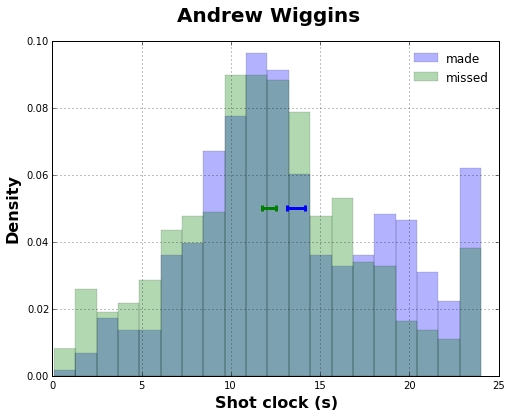

In [27]:
fig = plt.figure(figsize=(8,6), dpi=1600)
ax = fig.add_subplot(111)

madeShots = dfShots[(dfShots.SHOT_RESULT=='made') & (np.invert(np.isnan(dfShots.SHOT_CLOCK)))]
#madeShots = allShots[allShots.SHOT_RESULT=='made']
missedShots = dfShots[(dfShots.SHOT_RESULT=='missed') & (np.invert(np.isnan(dfShots.SHOT_CLOCK)))]

madeShots['SHOT_CLOCK'].hist(normed = True,bins=20,alpha=0.3,linewidth=0.4,label='made')
missedShots['SHOT_CLOCK'].hist(normed = True,bins=20,alpha=0.3,linewidth=0.4,label='missed')
plt.legend(loc='upper right',framealpha=0)

ax.set_xlabel('Shot clock (s)',fontsize=16,fontweight='bold')
ax.set_ylabel('Density',fontsize=16,fontweight='bold')
fig.suptitle('Andrew Wiggins',fontsize=20,fontweight='bold')

plt.errorbar(x=[made['mean']],y=[0.05],xerr=[[madeLow],[madeUp]],linewidth=3,capthick=3,ecolor='b')
plt.errorbar(x=[missed['mean']],y=[0.05],xerr=[[missedLow],[missedUp]],linewidth=3,capthick=3,ecolor='g')

plt.show()


In [28]:
#cMin,cSec = allShots['GAME_CLOCK'].str.split(':').str.get(0),allShots['GAME_CLOCK'].str.split(':').str.get(1)
cMin,cSec = allShots.loc[:,'GAME_CLOCK'].str.split(':').str.get(0),allShots.loc[:,'GAME_CLOCK'].str.split(':').str.get(1)

allShots.loc[:,'secGameClock'] = cMin.astype('int') * 60 + cSec.astype('int')
#allShots

In [29]:
# Dummify variables

pd.get_dummies(allShots[['W','LOCATION','FGM']])
allShots.loc[:,'gameWon'] = pd.get_dummies(allShots['W'])['W']
allShots.loc[:,'homeGame'] = pd.get_dummies(allShots['LOCATION'])['H']
allShots.loc[:,'is3Pointer'] = pd.get_dummies(allShots['PTS_TYPE'])[3]
q = pd.get_dummies(allShots['PERIOD'])[[2,3,4,5]]
allShots = pd.concat([allShots,q],axis=1)


In [30]:
dropThese = ['GAME_ID','MATCHUP','CLOSEST_DEFENDER','CLOSEST_DEFENDER_PLAYER_ID','GAME_CLOCK','SHOT_RESULT','LOCATION','W','PERIOD','PTS_TYPE','PTS']
[ allShots.drop(i, axis=1, inplace=True) for i in dropThese ] 



[None, None, None, None, None, None, None, None, None, None, None]

In [31]:
from sklearn import linear_model
from sklearn import cross_validation
import sklearn as sk


In [32]:
trainShots = allShots[1::2] #Odd rows
testShots = allShots[::2] #Even rows

In [33]:
scAllShots = pd.DataFrame(sk.preprocessing.scale(allShots),index=allShots.index,columns=allShots.columns)
scTrainShots = scAllShots[1::2] 
scTestShots = scAllShots[::2]

In [86]:
#Huzzah this one is generalized!
#Rebuild the restof the code around this


trainShots = allShots[1::2] #Odd rows
testShots = allShots[::2] #Even rows

def myLearning(myData,myMod,trainIdx,testIdx,respVar,scaleIt=False): #Make this a function of train/test set, scale, algorithm
    predCol = [col for col in allShots.columns if col != respVar]
    trainSet = eval('myData' + trainIdx)
    testSet = eval('myData' + testIdx)
    if scaleIt == True:
        myData = sk.preprocessing.scale(myData)
    print 'Algorithm used:\n' + myMod + '\n'
    myEst = eval(myMod)
    myEst.fit(
        trainSet[predCol],
        trainSet['FGM']
    )
    matches = np.count_nonzero(myEst.predict(testSet[predCol]) == testSet['FGM'])
    testLen = testSet.shape[0]
    print "Correctly classified:\n" + str(round(float(matches) / testLen * 100,2)) + '%'


myLearning(myData=allShots,myMod='linear_model.LogisticRegression()',trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=True) 

Algorithm used:
linear_model.LogisticRegression()

Correctly classified:
60.25%


In [55]:
#I'm developing this one to read in data and make train/test based on an index

def myLearning(myMod,trainSet,testSet,respVar,scaleIt=False): #Make this a function of train/test set, scale, algorithm
    predCol = [col for col in allShots.columns if col != respVar]
    if scaleIt == True:
        print 'Scale is true! Write some code to scale the data...'
    print 'Algorithm used:\n' + myMod + '\n'
    myEst = eval(myMod)
    myEst.fit(
        eval(trainSet)[predCol],
        eval(trainSet)['FGM']
    )
    matches = np.count_nonzero(myEst.predict(eval(testSet)[predCol]) == eval(testSet)['FGM'])
    testLen = eval(testSet).shape[0]
    print "Correctly classified:\n" + str(round(float(matches) / testLen * 100,2)) + '%'


myLearning(myMod='linear_model.LogisticRegression()',trainSet='trainShots',testSet='testShots',respVar='FGM') 

Algorithm used:
linear_model.LogisticRegression()

Correctly classified:
60.25%


In [ ]:
predCol = [col for col in allShots.columns if col != 'FGM']
print predCol

estLog = linear_model.LogisticRegression()
estLog.fit(trainShots[predCol],trainShots['FGM'])
estSVM = svm.SVC()
estSVM.fit(trainShots[predCol],trainShots['FGM'])
estscSVM = svm.SVC()
estscSVM.fit(scTrainShots[predCol],scTrainShots['FGM'])




In [ ]:
results = pd.DataFrame()
results['predLog'] = estLog.predict(testShots[predCol])
results['predSVM'] = estSVM.predict(testShots[predCol])

results['scPredSVM'] = estscSVM.predict(scTestShots[predCol])
#NuSVC, LinearSVC

In [ ]:
results['actual'] = np.array(testShots['FGM'])
results['scActual'] = np.array(scTestShots['FGM'])
results.head()

In [ ]:
results['logTF'] = results['predLog'] == results['actual']
results['svmTF'] = results['predSVM'] == results['actual']

results['scSvmTF'] = results['scPredSVM'] == results['scActual']

In [ ]:
print np.count_nonzero(results['logTF'])/float(len(results))*100
print np.count_nonzero(results['svmTF'])/float(len(results))*100

print np.count_nonzero(results['scSvmTF'])/float(len(results))*100

#trainShots[predCol]

In [ ]:
estLog = linear_model.LogisticRegression()
estLog.fit(trainShots[predCol],trainShots['FGM'])

In [ ]:
from sklearn import cross_validation

In [ ]:
predCol = [col for col in allShots.columns if col != 'FGM']
allShots = allShots.reset_index(drop=True)

loo = cross_validation.LeaveOneOut(len(allShots))
estLog = linear_model.LogisticRegression()
svmCorrect, logCorrect = 0, 0
for trainIdx, testIdx in loo:
    trainShots = allShots.loc[trainIdx]
    estLog = linear_model.LogisticRegression()
    estLog.fit(trainShots[predCol],trainShots['FGM'])
    estSVM = svm.SVC()
    estSVM.fit(trainShots[predCol],trainShots['FGM'])
    testShots = allShots.loc[testIdx]
    if int(estLog.predict(testShots[predCol])) == int(testShots['FGM']):
        logCorrect += 1
    if int(estSVM.predict(testShots[predCol])) == int(testShots['FGM']):
        svmCorrect += 1
logClass = round(logCorrect/float(len(allShots))*100,2)
svmClass = round(svmCorrect/float(len(allShots))*100,2)
print "Logistic regression prediction accuracy: " + str(logClass) + " \n"
print "Support vector machine prediction accuracy: " + str(svmClass)

In [ ]:
# Figuring out scaling. 

p = pd.DataFrame({'a': 20+50*np.random.randn(10),'b':np.random.randn(10)})
print np.std(sk.preprocessing.scale(p)[:,0]), np.std(sk.preprocessing.scale(p)[:,1])
print np.mean(sk.preprocessing.scale(p)[:,0]), np.mean(sk.preprocessing.scale(p)[:,1])